# SWOT Data Subsetting & Visualization # 
SWOT Data product used in this notebook: "SWOT Simulated Level-2 KaRIn SSH from MITgcm ECCO LLC4320 for Cal/Val Version 1" 

### Libraries ### 

In [4]:
### libraries ### 

# for pulling data from earthdata & subsetting 
import earthaccess 
import json 
from pathlib import Path 
import os 
import xarray as xr 
# for finding matching passes & plotting bounding box 
import geopandas as gpd 
from shapely.geometry import Polygon 
# for plot 
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker 
import numpy as np 

### Functions ### 

In [8]:
def get_granules(time_start, time_stop, folder, num_files): 
    '''
    This method uses the earthaccess library to search for SWOT simulated datasets within a specified time range, then download 
    these datasets into a given folder 
    
    Parameters: 
    time_start: string representing the beginning of the time range 
    time_stop: string representing the end of the time range 
    download_folder: path to folder where the datasets will be downloaded 
    
    Returns: nothing 
    '''
    
    datasets = earthaccess.search_data(short_name = "SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1", temporal = (time_start, time_stop)) 
    
    earthaccess.download(datasets[0:num_files], folder) 
    for item in os.listdir(folder): 
        if item.endswith(".zip"): # check for ".zip" extension 
            zip_ref = zipfile.ZipFile(f"{folder}/{item}") # create zipfile object 
            zip_ref.extractall(folder) # extract file to dir 
            zip_ref.close() # close file 

            
def matching_passes(minlon, minlat, maxlon, maxlat, plot=True): 
    ''' 
    This method finds all SWOT swaths that overlap with a specified bounding box and stores their corresponding pass numbers 
    as a pandas series  
    
    Parameters: 
    minlon, minlat, maxlon, maxlat: coordinates representing bounding box 
    plot: if true, the function will plot the bounding box and all overlapping swaths 
    
    Returns: pandas series object containing all pass numbers for passes that overlap with the specified bounding box 
    ''' 
    
    # store bounding box coordinates as polygon object (to use as geometry for geodataframe representing bounding box) 
    bbox_polygon = Polygon([(minlon, minlat), (maxlon, minlat), (maxlon, maxlat), (minlon, maxlat)]) 
    
    # read shapefile as geodataframe 
    # has info abt where each swath is & what pass number each swath corresponds to, and other info but this is the only info that matters for this function 
    swaths_gdf = gpd.read_file("./sph_science_swath/swot_science_orbit_sept2015-v2_swath.shp", crs="4326") # original 
    
    # swaths_gdf = gpd.read_file("./sph_calval_swath/swot_calval_orbit_june2015-v2_swath.shp", crs="4326") 
    # swaths_gdf = gpd.read_file("./shp_calval_nadir/swot_calval_orbit_june2015-v2_nadir.shp", crs="4326") 
    # swaths_gdf = gpd.read_file("./swot_calval_hr_Dec2022-v07_swath/swot_calval_hr_Dec2022-v07_swath.shp", crs="4326") 
    # swaths_gdf = gpd.read_file("./swot_calval_hr_Dec2022-v07_nadir/swot_calval_hr_Dec2022-v07_nadir.shp", crs="4326") 
    # swaths_gdf = gpd.read_file("./swot_science_hr_Aug2021-v05_shapefile_nadir/swot_science_hr_2.0s_4.0s_Aug2021-v5_nadir.shp", crs="4326")
    
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon], crs="4326") # geodataframe representing area enclosed by bounding box 
    
    overlap = gpd.sjoin(swaths_gdf, bbox_gdf) # new geodataframe only containing data from overlapping area (area within bounding box) 
    
    if plot: 
        print(f"{len(overlap.ID_PASS)} matching passes: {overlap.ID_PASS.values}") 
        fig = plt.figure(figsize=(10, 6)) 
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # axes object to store all elements of the plot 
        ax.gridlines(draw_labels=True) 
        ax.add_feature(cartopy.feature.OCEAN, color='lightblue') 
        ax.add_feature(cartopy.feature.COASTLINE) 
        overlap.plot(ax=ax) # plots the geodataframe on the previously defined axes 
        bbox_gdf.plot(ax=ax, color="w", alpha=0.6, zorder=3) # plots the bounding box on the same axes 
    return overlap.ID_PASS 


def subset(file, folder, var_name, minlon, minlat, maxlon, maxlat): 
    ''' 
    This method creates a subset of a specified dataset that only includes values of a specified variable that correspond to 
    latitude/longitude coordinates that fall within the specified bounding box 
    
    Parameters: 
    file: name of file to be subset 
    folder: path to folder where the file is stored 
    var_name: name of variable to be included in subset 
    minlon, minlat, maxlon, maxlat: coordinates representing bounding box 
    
    Returns: subset of original dataset (xarray dataset object) 
    ''' 
    
    ds = xr.open_dataset(Path(f"{str(folder)}/{file}"), engine="netcdf4") # open netcdf file as xarray dataset 

    lon, lat = ds['longitude_nadir'], ds['latitude_nadir'] # xarray DataArrays representing lon & lat of nadir point 
    mask = (lon > minlon) & (lon < maxlon) & (lat > minlat) & (lat < maxlat) # xarray dataarray mask to filter lat & lon coordinates within the bounding box 
    dout = {}
    if mask.sum() > 1: # check whether any coordinates from the dataset are within the bounding box  
        dout[var_name] = ds[var_name][mask, :] # store all values of the specified variable that correspond to valid lat/lon coordinates 
    subset = xr.Dataset(dout) # subset to use for plot 
    return subset 


### Variables: ### 

In [18]:
# note: hard coded vals are for testing 

# time range: 
start = "2011-11-13" 
stop = "2012-11-12" 
# start = input("Please enter the date range in the following format: yyyy-mm-dd \nstart of time range: ") 
# stop = input("end of time range: ") 

# path to folder where you want to download the datasets: 
folder = Path("./swot_data") 
# path = input("relative path to folder where you want to download the datasets: ") 
# folder = Path(path) 

# number of files to download (since there are often thousands of files) 
file_count = 30 
# file_count = int(input("Number of files you would like to download: ")) 

# bounding box: 
minlon, minlat, maxlon, maxlat = [60,-50,80,-20] 
#minlon, minlat, maxlon, maxlat = [int(x) for x in input("bounding box coordinates (format: min longitude, min latitude, max longitude, max latitude): ").split(", ")] 

# name of variable to be included in the subset: 
var = "ssha_karin_2" 
# var = input("variable name: ") 

### Find & Download Granules: ### 

In [31]:
### log in to earthdata & download matching granules ### 

earthaccess.login() # log in to earthdata (defaults to using netrc file but will ask for credentials if that doesn't work) 

get_granules(start, stop, folder, file_count) 

Granules found: 10288
 Getting 30 granules, approx download size: 0.3 GB


QUEUEING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/30 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
### create list of all downloaded file names ### 

downloaded_files = list() 
if len(os.listdir(folder)) > 0: 
    downloaded_files = [file.name for file in folder.glob("*.nc")] 
print(f"files downloaded: {len(downloaded_files)}") 

files downloaded: 30


### Find Files that Contain Data Within the Bounding Box: ### 

In [ ]:
### method 1: use matching_passes function ### 

passes = matching_passes(minlon, minlat, maxlon, maxlat).tolist() # list of all pass numbers that intersect with bounding box 
valid_files = list() 
for file in downloaded_files: 
    pass_num = xr.open_dataset(Path(f"./swot_data/{file}"), engine="netcdf4").attrs["pass_number"] # pass num of this dataset 
    if pass_num in passes: 
        valid_files.append(file) # add dataset to "valid files" list if the corresponding pass num intersects with the bounding box

print(f"valid files: {valid_files}") 

i = int(input("Please enter the index of the file that you would like to subset: ") 

subset_data = subset(valid_files[i], folder, var, minlon, minlat, maxlon, maxlat) 

In [11]:
### method 2: loop through downloaded files ### 

file_options = list() # list to store names of files with data found within the bounding box 
for file in downloaded_files: 
    subset_result = subset(file, folder, var, minlon, minlat, maxlon, maxlat) 
    if len(subset_result.keys()) > 0: 
        file_options.append(file) # add name of this file to "file options" list if the resulting subset is not empty 

while len(file_options) == 0: 
    minlon, minlat, maxlon, maxlat = [int(x) for x in input("None of the downloaded files contain data within that bounding box. Please try another bounding box (format: min longitude, min latitude, max longitude, max latitude): ").split(", ")] 
    for file in downloaded_files: 
        subset_result = subset(file, folder, var, minlon, minlat, maxlon, maxlat) 
        if len(subset_result.keys()) > 0: 
            file_options.append(file) 
            
print(f"file options: {file_options}") 

index = int(input("Please enter the index of the file that you would like to subset: ") 

subset_data = subset(file_options[index], folder, var, minlon, minlat, maxlon, maxlat) 

['SWOT_L2_LR_SSH_Expert_002_001_20111113T235037_20111114T004142_DG10_01.nc', 'SWOT_L2_LR_SSH_Expert_001_016_20111113T124625_20111113T133730_DG10_01.nc', 'SWOT_L2_LR_SSH_Expert_001_001_20111113T000000_20111113T005105_DG10_01.nc']


<GeoAxesSubplot:>

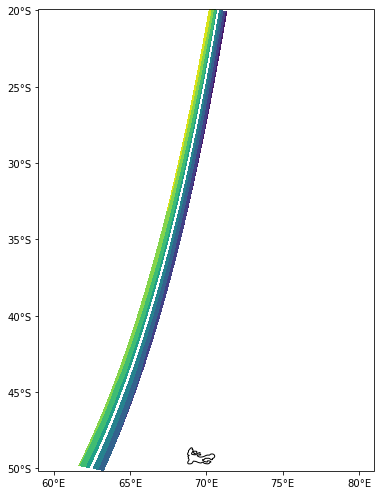

In [40]:
### plot the subset: ### 

# set plot size 
fig = plt.figure(figsize=(11,8.5)) 

# set axes using specified map projection
ax=fig.add_subplot(projection=ccrs.PlateCarree())

# make filled contour plot - for plotting data along 3 dimensions on a 2d surface 
ax.contourf(subset_data['longitude'], subset_data['latitude'], subset_data['ssha_karin_2'], transform = ccrs.PlateCarree())

#ax.set_global() 
ax.coastlines() 

# define xticks for longitude
ax.set_xticks(np.arange(-180,181,5), crs=ccrs.PlateCarree()) # -180˚-180˚, 5˚ increments 
lon_formatter = cticker.LongitudeFormatter() # to make sure the axis labels include ˚E/˚W instead of only integers 
ax.xaxis.set_major_formatter(lon_formatter) 

# define yticks for latitude
ax.set_yticks(np.arange(-90,91,5), crs=ccrs.PlateCarree()) # -90˚-90˚, 5˚ increments 
lat_formatter = cticker.LatitudeFormatter() # to make sure the axis labels include ˚N/˚S instead of only integers 
ax.yaxis.set_major_formatter(lat_formatter) 

# plot the bounding box to highlight this area 
bbox_polygon = Polygon([(minlon, minlat), (maxlon, minlat), (maxlon, maxlat), (minlon, maxlat)]) 
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon]) # geodataframe representing area enclosed by bounding box 
bbox_gdf.plot(ax=ax, facecolor="none", edgecolor="none") # plots the bounding box on the same axes 


<GeoAxesSubplot:>

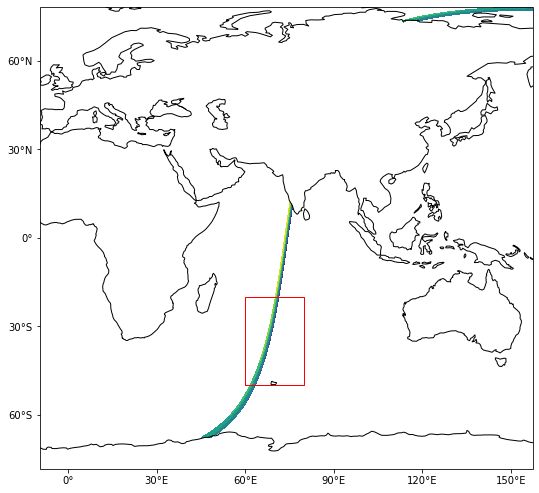

In [41]:
### plot all vals of a variable from the original dataset & highlight area within bounding box ### 

# set plot size 
fig = plt.figure(figsize=(11,8.5)) 

# set axes using specified map projection
ax=fig.add_subplot(projection=ccrs.PlateCarree())

dataset = xr.open_dataset(f"{str(folder)}/{file_options[0]}", engine="netcdf4") 

ax.contourf(dataset['longitude'], dataset['latitude'], dataset[var], transform = ccrs.PlateCarree())

# add coastlines 
ax.coastlines() 

#ax.gridlines(draw_labels=True) 

#define xticks for longitude
ax.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree()) # -180˚-180˚, 30˚ increments 
lon_formatter = cticker.LongitudeFormatter() # to make sure the axis labels include ˚E/˚W instead of only integers 
ax.xaxis.set_major_formatter(lon_formatter) 

#define yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree()) # -90˚-90˚, 30˚ increments 
lat_formatter = cticker.LatitudeFormatter() # to make sure the axis labels include ˚N/˚S instead of only integers 
ax.yaxis.set_major_formatter(lat_formatter) 

# plot the bounding box to highlight this area 
bbox_polygon = Polygon([(minlon, minlat), (maxlon, minlat), (maxlon, maxlat), (minlon, maxlat)]) 
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_polygon]) # geodataframe representing area enclosed by bounding box 
bbox_gdf.plot(ax=ax, facecolor="none", edgecolor="red") # plots the bounding box on the same axes as the dataset 